# BM25 Retrieval Evaluation

This notebook evaluates BM25 retrieval on:
1. Content field
2. Metadata field

For all 10 legal queries.

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

from src.data_loader import load_data, prepare_data, get_documents_by_field
from src.queries import get_all_queries
from src.bm25_retriever import BM25Retriever, evaluate_bm25, save_results
from src.evaluation import print_query_results, create_comparison_table
from src.config import RESULTS_DIR, TOP_K

sns.set_style('whitegrid')
print("✓ Imports successful")

✓ Imports successful


## 1. Load and Prepare Data

In [2]:
# Load data
df = load_data()
df = prepare_data(df)

print(f"Loaded {len(df)} documents")

# Get document lists
documents_content = get_documents_by_field(df, 'content')
documents_metadata = get_documents_by_field(df, 'metadata')

# Get queries
queries = get_all_queries()
print(f"Loaded {len(queries)} queries")

Loading data from d:\Core\_Code D\LegalAI-model-eval\notebooks\..\data\acts_with_metadata.tsv...
Loaded 7067 records
Creating metadata field...
Metadata field created
Loaded 7067 documents
Loaded 10 queries


## 2. BM25 Retrieval on Content

In [3]:
# Evaluate BM25 on content
results_content = evaluate_bm25(
    documents=documents_content,
    queries=queries,
    top_k=TOP_K,
    field_name="content"
)


BM25 EVALUATION - CONTENT

Tokenizing 7067 documents for BM25...
Building BM25 index...
BM25 index built successfully
Processing query 1/10: What are the procedures for presidential elections...
Processing query 2/10: What are the tax obligations and payment requireme...
Processing query 3/10: What are the penalty provisions for bribery and un...
Processing query 4/10: What is the process for filing appeals to the Boar...
Processing query 5/10: What are the voting procedures and ballot requirem...
Processing query 6/10: How are taxes assessed and collected, and what pow...
Processing query 7/10: What are the establishment provisions and governan...
Processing query 8/10: What are the import duty requirements and customs ...
Processing query 9/10: What is the nomination process and requirements fo...
Processing query 10/10: What are the powers and functions of the Commissio...

Results:
  Average retrieval time: 0.0401 seconds
  Total queries: 10



In [4]:
# Display results for first query
query_idx = 0
query_result = results_content['results'][query_idx]

print_query_results(
    df=df,
    query=query_result['query'],
    indices=query_result['retrieved_indices'],
    scores=query_result['scores'],
    top_n=3,
    field='content'
)


Query: What are the procedures for presidential elections when the office becomes vacant?

Rank 1 (Score: 35.3770):
  Key: 1981-1-02
  Title: Presidential Elections (Special Provisions)
  Content (first 200 chars): C ACT, No. 2 OF 1981 [Certified on 29th January, 1981]  Published as a Supplement to Part II of the Gazette of the Democratic Socialist Republic of Sri Lanka of January 30. 1981     Act, No. 2 of 1981...

Rank 2 (Score: 33.4456):
  Key: 2023-8-09
  Title: Anti-Corruption
  Content (first 200 chars): 7 Act, No. 9 of 2023
 (c)
the assets and liabilities of each of his dependant
children irrespective of their age;
 (d)
assets and liabilities of any other person’s dependant
on him irrespective of the...

Rank 3 (Score: 31.8071):
  Key: 2004-11-14
  Title: Elections (Special Provinces)
  Content (first 200 chars): 5
Elections (Special  Provisions)
 Act, No. 14 of 2004
 PART  III
 AMENDMENTS TO THE PRESIDENTIAL ELECTIONS
ACT, NO. 15 OF 1981
 9.
Section 35 of the Presidential Elec

## 3. BM25 Retrieval on Metadata

In [5]:
# Evaluate BM25 on metadata
results_metadata = evaluate_bm25(
    documents=documents_metadata,
    queries=queries,
    top_k=TOP_K,
    field_name="metadata"
)


BM25 EVALUATION - METADATA

Tokenizing 7067 documents for BM25...
Building BM25 index...
BM25 index built successfully
Processing query 1/10: What are the procedures for presidential elections...
Processing query 2/10: What are the tax obligations and payment requireme...
Processing query 3/10: What are the penalty provisions for bribery and un...
Processing query 4/10: What is the process for filing appeals to the Boar...
Processing query 5/10: What are the voting procedures and ballot requirem...
Processing query 6/10: How are taxes assessed and collected, and what pow...
Processing query 7/10: What are the establishment provisions and governan...
Processing query 8/10: What are the import duty requirements and customs ...
Processing query 9/10: What is the nomination process and requirements fo...
Processing query 10/10: What are the powers and functions of the Commissio...

Results:
  Average retrieval time: 0.0338 seconds
  Total queries: 10



In [6]:
# Display results for first query
query_result = results_metadata['results'][query_idx]

print_query_results(
    df=df,
    query=query_result['query'],
    indices=query_result['retrieved_indices'],
    scores=query_result['scores'],
    top_n=3,
    field='metadata'
)


Query: What are the procedures for presidential elections when the office becomes vacant?

Rank 1 (Score: 35.4127):
  Key: 1981-1-02
  Title: Presidential Elections (Special Provisions)
  Metadata (first 200 chars): Title: Presidential Elections (Special Provisions) | Section: Provisions for Election of President upon Vacancy under Article 38 and Special Provisions Act | Keywords: Presidential Elections, Special ...

Rank 2 (Score: 25.8931):
  Key: 1981-3-15
  Title: Presidential Elections
  Metadata (first 200 chars): Title: Presidential Elections | Section: Regulation procedures for identity declarations, ballot papers, and rejection handling by counting officer | Keywords: act, declaration of identity, ballot pap...

Rank 3 (Score: 25.0786):
  Key: 1981-3-15
  Title: Presidential Elections
  Metadata (first 200 chars): Title: Presidential Elections | Section: Commissioner powers and procedures for declaration of President elect and related contingencies | Keywords: Statement certif

## 4. Compare Content vs Metadata Retrieval

In [7]:
# Create comparison dataframe
comparison_data = []

for i, query in enumerate(queries):
    content_result = results_content['results'][i]
    metadata_result = results_metadata['results'][i]
    
    comparison_data.append({
        'Query ID': query['id'],
        'Category': query['category'],
        'Content Time (s)': content_result['retrieval_time'],
        'Metadata Time (s)': metadata_result['retrieval_time'],
        'Content Top Score': content_result['scores'][0] if content_result['scores'] else 0,
        'Metadata Top Score': metadata_result['scores'][0] if metadata_result['scores'] else 0,
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df

,Query ID,Category,Content Time (s),Metadata Time (s),Content Top Score,Metadata Top Score
0,1,Constitutional Law,0.039409,0.036762,35.376956,35.412690
1,2,Tax Law,0.042540,0.038419,34.060866,33.043346
2,3,Electoral Law,0.038892,0.031311,44.107665,34.375113
3,4,Procedural Law,0.050417,0.043788,57.879389,43.434335
4,5,Electoral Law,0.034511,0.028105,32.872124,31.478454
5,6,Tax Law,0.037742,0.030512,28.819594,23.147236
6,7,Administrative Law,0.044290,0.033228,38.035420,27.992878
7,8,Customs Law,0.041494,0.035002,35.742661,30.821870
8,9,Constitutional Law,0.031562,0.027336,31.143731,28.658449
9,10,Tax Law,0.039665,0.033794,38.389451,25.657453


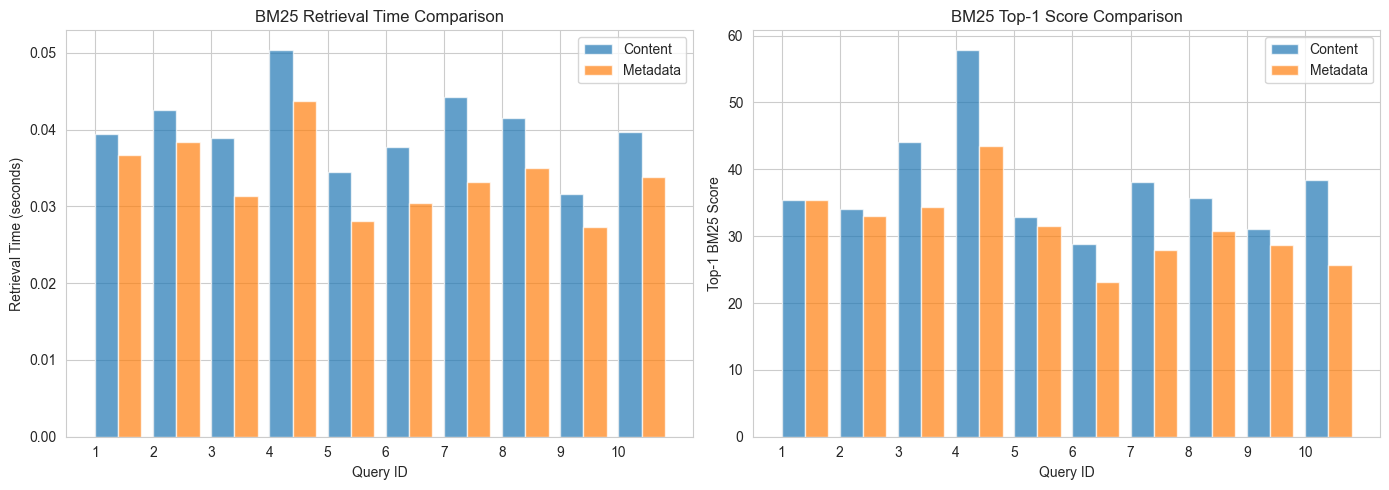

In [8]:
# Visualize retrieval times
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Retrieval time comparison
axes[0].bar(range(len(queries)), comparison_df['Content Time (s)'], 
            alpha=0.7, label='Content', width=0.4, align='edge')
axes[0].bar([x + 0.4 for x in range(len(queries))], comparison_df['Metadata Time (s)'], 
            alpha=0.7, label='Metadata', width=0.4, align='edge')
axes[0].set_xlabel('Query ID')
axes[0].set_ylabel('Retrieval Time (seconds)')
axes[0].set_title('BM25 Retrieval Time Comparison')
axes[0].legend()
axes[0].set_xticks(range(len(queries)))
axes[0].set_xticklabels([q['id'] for q in queries])

# Top score comparison
axes[1].bar(range(len(queries)), comparison_df['Content Top Score'], 
            alpha=0.7, label='Content', width=0.4, align='edge')
axes[1].bar([x + 0.4 for x in range(len(queries))], comparison_df['Metadata Top Score'], 
            alpha=0.7, label='Metadata', width=0.4, align='edge')
axes[1].set_xlabel('Query ID')
axes[1].set_ylabel('Top-1 BM25 Score')
axes[1].set_title('BM25 Top-1 Score Comparison')
axes[1].legend()
axes[1].set_xticks(range(len(queries)))
axes[1].set_xticklabels([q['id'] for q in queries])

plt.tight_layout()
plt.show()

In [9]:
# Summary statistics
print("BM25 Retrieval Summary:")
print("="*60)
print(f"\nContent Field:")
print(f"  Avg retrieval time: {results_content['avg_retrieval_time']:.4f}s")
print(f"  Avg top-1 score: {comparison_df['Content Top Score'].mean():.4f}")
print(f"\nMetadata Field:")
print(f"  Avg retrieval time: {results_metadata['avg_retrieval_time']:.4f}s")
print(f"  Avg top-1 score: {comparison_df['Metadata Top Score'].mean():.4f}")
print(f"\nSpeed comparison: Metadata is {results_content['avg_retrieval_time']/results_metadata['avg_retrieval_time']:.2f}x faster")

BM25 Retrieval Summary:

Content Field:
  Avg retrieval time: 0.0401s
  Avg top-1 score: 37.6428

Metadata Field:
  Avg retrieval time: 0.0338s
  Avg top-1 score: 31.4022

Speed comparison: Metadata is 1.18x faster


## 5. Analyze Results for Specific Queries

In [10]:
# Interactive query explorer
def explore_query(query_id):
    """Display detailed results for a specific query."""
    query_idx = query_id - 1
    query = queries[query_idx]
    
    print(f"\n{'='*80}")
    print(f"QUERY {query_id}: {query['query']}")
    print(f"Category: {query['category']}")
    print(f"{'='*80}\n")
    
    # Content results
    print("\n--- CONTENT FIELD RESULTS ---")
    content_result = results_content['results'][query_idx]
    print_query_results(
        df, query['query'], 
        content_result['retrieved_indices'],
        content_result['scores'],
        top_n=3, field='content'
    )
    
    # Metadata results
    print("\n--- METADATA FIELD RESULTS ---")
    metadata_result = results_metadata['results'][query_idx]
    print_query_results(
        df, query['query'],
        metadata_result['retrieved_indices'],
        metadata_result['scores'],
        top_n=3, field='metadata'
    )

# Example: Explore query 1
explore_query(1)


QUERY 1: What are the procedures for presidential elections when the office becomes vacant?
Category: Constitutional Law


--- CONTENT FIELD RESULTS ---

Query: What are the procedures for presidential elections when the office becomes vacant?

Rank 1 (Score: 35.3770):
  Key: 1981-1-02
  Title: Presidential Elections (Special Provisions)
  Content (first 200 chars): C ACT, No. 2 OF 1981 [Certified on 29th January, 1981]  Published as a Supplement to Part II of the Gazette of the Democratic Socialist Republic of Sri Lanka of January 30. 1981     Act, No. 2 of 1981...

Rank 2 (Score: 33.4456):
  Key: 2023-8-09
  Title: Anti-Corruption
  Content (first 200 chars): 7 Act, No. 9 of 2023
 (c)
the assets and liabilities of each of his dependant
children irrespective of their age;
 (d)
assets and liabilities of any other person’s dependant
on him irrespective of the...

Rank 3 (Score: 31.8071):
  Key: 2004-11-14
  Title: Elections (Special Provinces)
  Content (first 200 chars): 5
Elections (

In [11]:
# Explore another query of interest
explore_query(2)


QUERY 2: What are the tax obligations and payment requirements for businesses with quarterly turnover?
Category: Tax Law


--- CONTENT FIELD RESULTS ---

Query: What are the tax obligations and payment requirements for businesses with quarterly turnover?

Rank 1 (Score: 34.0609):
  Key: 2006-3-10
  Title: Inland Revenue
  Content (first 200 chars): Commissioner-General under that Chapter, against any or all
of the partners of such partnership for the recovery of such
tax in default.
 For the purposes of this section “any quarterly instalment
of ...

Rank 2 (Score: 33.7898):
  Key: 2006-3-10
  Title: Inland Revenue
  Content (first 200 chars): 14 Act, No. 10 of 2006
 or continued to be owner or joint owners of such assets, the
person or partnership becoming owner of such assets, in
consequence of such change shall be charged with the income...

Rank 3 (Score: 32.9191):
  Key: 2006-3-10
  Title: Inland Revenue
  Content (first 200 chars): 18 Act, No. of 2006
 (2) The Commissioner-Genera

## 6. Save Results

In [12]:
# Save both results
save_results(results_content, RESULTS_DIR / "bm25_content_results.json")
save_results(results_metadata, RESULTS_DIR / "bm25_metadata_results.json")

# Save comparison table
comparison_df.to_csv(RESULTS_DIR / "bm25_comparison.csv", index=False)
print("\nAll results saved successfully!")

Results saved to d:\Core\_Code D\LegalAI-model-eval\notebooks\..\results\bm25_content_results.json
Results saved to d:\Core\_Code D\LegalAI-model-eval\notebooks\..\results\bm25_metadata_results.json

All results saved successfully!


## Summary

BM25 evaluation complete!

Key findings:
- BM25 retrieval tested on both content and metadata fields
- Metadata retrieval is generally faster due to shorter documents
- Content retrieval may capture more contextual information
- Results saved for comparison with FAISS and reranking

Next steps:
- Build FAISS indices (notebook 03)
- Compare with dense retrieval
- Apply reranking (notebook 05)